In [2]:
cd /atlas/u/madeline/multi-fairgen/src

/atlas/u/madeline/multi-fairgen/src


In [3]:
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from flows.models.maf import MAF

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
pwd

'/atlas/u/madeline/multi-fairgen/src'

In [6]:
cd /atlas/u/kechoi/pykliep/

/atlas/u/kechoi/pykliep


# Dataset

In [7]:
import torch
from sklearn.linear_model import LogisticRegression
from pykliep import DensityRatioEstimator

In [8]:
# rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/source.npz')
# X = rec['x']
# y = rec['y']

# rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/target.npz')
# Z = rec['x']
# u = rec['y']

# rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/target_test.npz')
# Z_test = rec['x']
# u_test = rec['y']
num_trials = 10
Xs = []
ys = []
Zs = []
us = []

rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/target_test.npz')
Z_test = rec['x']
u_test = rec['y']
Z_tests = []
u_tests = []
for i in range(num_trials):
    X = np.load(f'/atlas/u/madeline/multi-fairgen/data/kmm/X_{i}.npy')
    Z = np.load(f'/atlas/u/madeline/multi-fairgen/data/kmm/Z_{i}.npy') 
    y = np.load(f'/atlas/u/madeline/multi-fairgen/data/kmm/y_{i}.npy')
    u = np.load(f'/atlas/u/madeline/multi-fairgen/data/kmm/u_{i}.npy')
    Z_test = np.load(f'/atlas/u/madeline/multi-fairgen/data/kmm/Z_test_{i}.npy')
    u_test = np.load(f'/atlas/u/madeline/multi-fairgen/data/kmm/u_test_{i}.npy')
    Xs.append(X)
    Zs.append(Z)
    ys.append(y)
    us.append(u)
    Z_tests.append(Z_test)
    u_tests.append(u_test)    

# Load flows

In [9]:
def load_flow(restore_file):
    model = MAF(5, 
                2, 
                100, 
                1, 
                None, 
                'relu', 
                'sequential', 
                batch_norm=True)
    state = torch.load(os.path.join(restore_file, "model_checkpoint.pt"), map_location=device)
    model.load_state_dict(state['model_state'])
    model = model.to(device)
    model.eval()
    return model

In [10]:
device = 'cpu'
flows = []
for i in range(num_trials):   
    restore_file = f'/atlas/u/madeline/multi-fairgen/src/flows/results/kmm_synthetic_maf_trial_{i}/'
    flow = load_flow(restore_file)
    flows.append(flow)

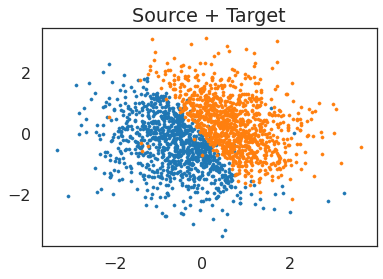

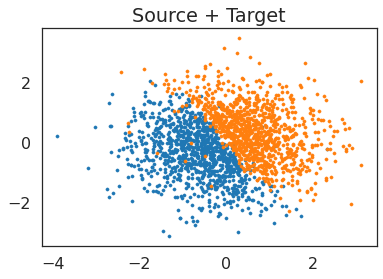

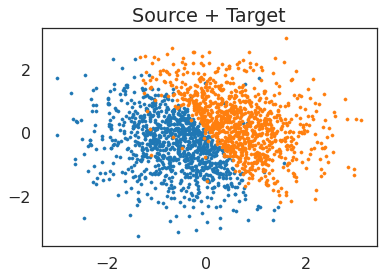

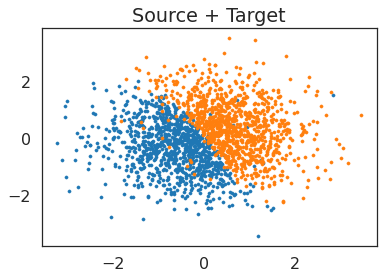

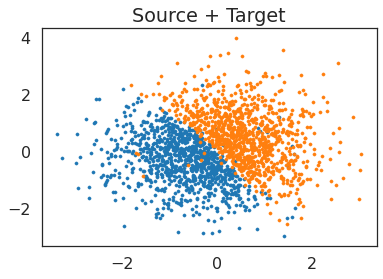

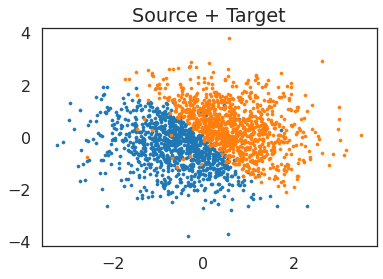

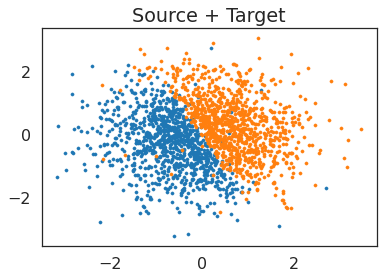

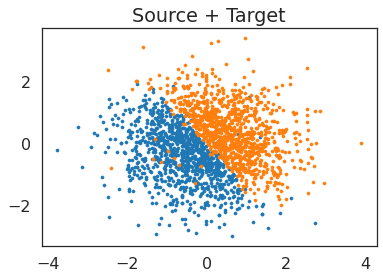

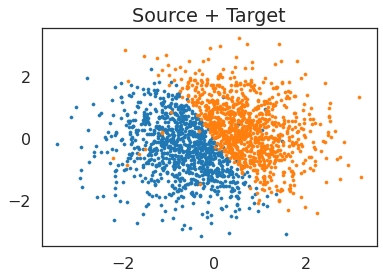

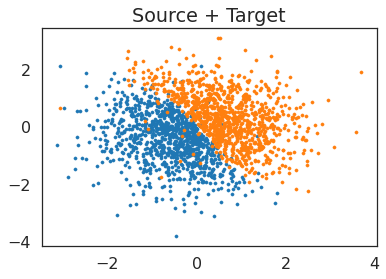

In [11]:
# encode data points
flow_Xs = []
flow_Zs = []
for i, (X, Z) in enumerate(zip(Xs, Zs)):
    flow = flows[i]
    flow_X, _ = flow.forward(torch.from_numpy(X).cpu().float())
    flow_Z, _ = flow.forward(torch.from_numpy(Z).cpu().float())
    plt.clf()
    plt.scatter(flow_X[:,0].data.cpu().numpy(), flow_X[:,1].data.cpu().numpy(), s=10)
    plt.scatter(flow_Z[:,0].data.cpu().numpy(), flow_Z[:,1].data.cpu().numpy(), s=10)

    plt.title('Source + Target')
    plt.show()
    flow_Xs.append(flow_X)
    flow_Zs.append(flow_Z)

# Train classifiers

## 1. Naive

In [12]:
naive_errs = []
naive_err_unseens = []
for X, y, Z, u, Z_test, u_test in zip(Xs, ys, Zs, us, Z_tests, u_tests):
    clf1 = LogisticRegression()
    clf1.fit(X, y)
    
    naive_preds = clf1.predict(Z)
    naive_preds_unseen = clf1.predict(Z_test)
    naive_err = np.mean(naive_preds != u, axis=0)
    naive_err_unseen = np.mean(naive_preds_unseen != u_test, axis=0)
    
    naive_errs.append(naive_err)
    naive_err_unseens.append(naive_err_unseen)
avg_naive_err = sum(naive_errs)/len(naive_errs)
avg_naive_err_unseen = sum(naive_err_unseens)/len(naive_err_unseens)
# note that naive classifier actually doesn't see either Z or Z_test during fitting
print('Avg test error on seen target dataset: ', avg_naive_err)
print('Std: ', np.std(naive_errs), '\n')
print('Avg unseen test error: ', avg_naive_err_unseen)
print('Std: ', np.std(naive_err_unseens))

Avg test error on seen target dataset:  0.2386
Std:  0.0404677649494014 

Avg unseen test error:  0.236
Std:  0.04559385923564707


## 2. DRE

### 2.1 X-DRE

In [13]:
best_avg_x_err = float('inf')
x_errs = []
x_unseen_errs = []
for X, y, Z, u, Z_test, u_test in zip(Xs, ys, Zs, us, Z_tests, u_tests):
    kliep = DensityRatioEstimator()
    kliep.fit(X, Z)
    x_weights = kliep.predict(X)
    clf2 = LogisticRegression()
    clf2.fit(X, y, sample_weight=x_weights)

    x_adapt_preds = clf2.predict(Z)
    x_adapt_err = np.mean(x_adapt_preds != u, axis=0)
    x_errs.append(x_adapt_err)

    x_adapt_unseen_preds = clf2.predict(Z_test)
    x_adapt_unseen_err = np.mean(x_adapt_unseen_preds != u_test, axis=0)
    x_unseen_errs.append(x_adapt_unseen_err)

avg_x_err = sum(x_errs)/len(x_errs)

/atlas/u/kechoi/pykliep/pykliep.py:168: RuntimeWarning: divide by zero encountered in true_divide
  out += epsilon*np.dot(np.transpose(A),1./np.dot(A,out))
/atlas/u/kechoi/pykliep/pykliep.py:168: RuntimeWarning: overflow encountered in true_divide
  out += epsilon*np.dot(np.transpose(A),1./np.dot(A,out))
/atlas/u/kechoi/pykliep/pykliep.py:168: RuntimeWarning: divide by zero encountered in true_divide
  out += epsilon*np.dot(np.transpose(A),1./np.dot(A,out))
/atlas/u/kechoi/pykliep/pykliep.py:168: RuntimeWarning: overflow encountered in true_divide
  out += epsilon*np.dot(np.transpose(A),1./np.dot(A,out))
/atlas/u/kechoi/pykliep/pykliep.py:168: RuntimeWarning: divide by zero encountered in true_divide
  out += epsilon*np.dot(np.transpose(A),1./np.dot(A,out))
/atlas/u/kechoi/pykliep/pykliep.py:168: RuntimeWarning: overflow encountered in true_divide
  out += epsilon*np.dot(np.transpose(A),1./np.dot(A,out))
/atlas/u/kechoi/pykliep/pykliep.py:168: RuntimeWarning: divide by zero encountered

In [13]:
print('Avg test error on seen target dataset: ', avg_x_err, 'Std: ', np.std(x_errs))
print('Unseen avg test error: ', np.mean(x_unseen_errs), 'Std: ', np.std(x_unseen_errs))

Avg test error on seen target dataset:  0.16490000000000002 Std:  0.046248135097536634
Unseen avg test error:  0.1625 Std:  0.05477088642700609


### 2.1 Z-DRE

In [14]:
z_errs = []
z_unseen_errs = []
for flow_X, y, flow_Z, u, Z_test, u_test in zip(flow_Xs, ys, flow_Zs, us, Z_tests, u_tests):    
    kliep = DensityRatioEstimator()
    kliep.fit(flow_X.detach().cpu().numpy(), flow_Z.detach().cpu().numpy())
    z_weights = kliep.predict(flow_X.detach().cpu().numpy())
    clf2 = LogisticRegression()
    clf2.fit(X, y, sample_weight=z_weights)

    z_adapt_preds = clf2.predict(Z)
    z_adapt_err = np.mean(z_adapt_preds != u, axis=0)
    z_errs.append(z_adapt_err)

    z_adapt_unseen_preds = clf2.predict(Z_test)
    z_adapt_unseen_err = np.mean(z_adapt_unseen_preds != u_test, axis=0)
    z_unseen_errs.append(z_adapt_unseen_err)

avg_z_err = sum(z_errs)/len(z_errs)

/atlas/u/kechoi/pykliep/pykliep.py:168: RuntimeWarning: divide by zero encountered in true_divide
  out += epsilon*np.dot(np.transpose(A),1./np.dot(A,out))
/atlas/u/kechoi/pykliep/pykliep.py:168: RuntimeWarning: divide by zero encountered in true_divide
  out += epsilon*np.dot(np.transpose(A),1./np.dot(A,out))
/atlas/u/kechoi/pykliep/pykliep.py:168: RuntimeWarning: divide by zero encountered in true_divide
  out += epsilon*np.dot(np.transpose(A),1./np.dot(A,out))
/atlas/u/kechoi/pykliep/pykliep.py:168: RuntimeWarning: divide by zero encountered in true_divide
  out += epsilon*np.dot(np.transpose(A),1./np.dot(A,out))
/atlas/u/kechoi/pykliep/pykliep.py:168: RuntimeWarning: divide by zero encountered in true_divide
  out += epsilon*np.dot(np.transpose(A),1./np.dot(A,out))
/atlas/u/kechoi/pykliep/pykliep.py:168: RuntimeWarning: divide by zero encountered in true_divide
  out += epsilon*np.dot(np.transpose(A),1./np.dot(A,out))
/atlas/u/kechoi/pykliep/pykliep.py:168: RuntimeWarning: divide b

In [15]:
print('Avg test error on seen target dataset: ', avg_z_err, 'Std: ', np.std(z_errs))
print('Unseen avg test error: ', np.mean(z_unseen_errs), 'Std: ', np.std(z_unseen_errs))

Avg test error on seen target dataset:  0.12789999999999999 Std:  0.02488151924621967
Unseen avg test error:  0.12510000000000002 Std:  0.02685684270348992


In [16]:
z_unseen_errs

[0.13, 0.131, 0.155, 0.144, 0.084, 0.116, 0.103, 0.096, 0.115, 0.177]

NameError: name 'best_x_unseen_errs' is not defined

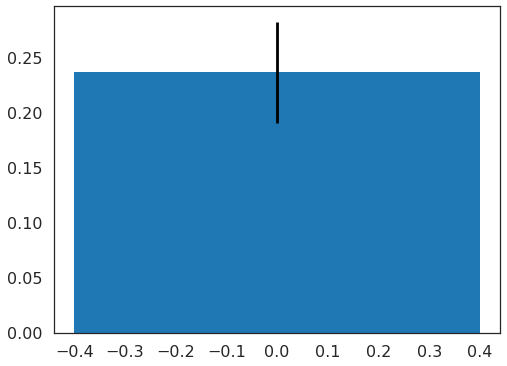

In [16]:
width = 0.2
plt.figure(figsize=(8,6))
plt.bar(0, avg_naive_err_unseen,yerr=np.std(naive_err_unseens), label='baseline')
        
plt.bar(1,  np.mean(best_x_unseen_errs), yerr=np.std(best_x_unseen_errs), label='x-dre')
plt.bar(2,  np.mean(best_z_unseen_errs), yerr=np.std(best_z_unseen_errs), label='z-dre')

plt.xticks(np.arange(3), ['Baseline', 'X-DRE', 'Z-DRE (ours)'])
plt.title('KLIEP test error')
plt.ylim(0, 0.30)
plt.legend()
plt.show()

In [10]:
# Train via KLIEP
clf = LogisticRegression()
clf.fit(X, y, sample_weight=weights)
pred_adapt = clf.predict(Z)

# Train a naive logistic regressor
lr = LogisticRegression().fit(X, y)

# Make predictions
pred_naive = lr.predict(Z)


# Compute error rates
print('Error naive: ' + str(np.mean(pred_naive != u, axis=0)))
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))

Error naive: 0.297
Error adapt: 0.233


In [11]:
pred_adapt_test = clf.predict(Z_test)
pred_naive_test = lr.predict(Z_test)

# Compute error rates
print('Error naive: ' + str(np.mean(pred_naive_test != u_test, axis=0)))
print('Error adapt: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error naive: 0.286
Error adapt: 0.208


What about the flow?

In [12]:
cd ../multi-fairgen/src/

/atlas/u/kechoi/multi-fairgen/src


In [13]:
device = 'cuda'
restore_file = 'flows/results/kmm_flow/'
state = torch.load(os.path.join(restore_file, "best_model_checkpoint.pt"), map_location='cuda')
print(state['epoch'])

85


In [14]:
from flows.models.maf import MAF

def load_flow():
    model = MAF(5, 
                2, 
                100, 
                1, 
                None, 
                'relu', 
                'sequential', 
                batch_norm=True)
    restore_file = 'flows/results/kmm_flow/'
    state = torch.load(os.path.join(restore_file, "model_checkpoint.pt"), map_location='cuda')
    model.load_state_dict(state['model_state'])
    model = model.to(device)
    return model

flow = load_flow()
flow.eval()

MAF(
  (net): FlowSequential(
    (0): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (1): BatchNorm()
    (2): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (3): BatchNorm()
    (4): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      

Text(0.5, 1.0, 'Source + Target')

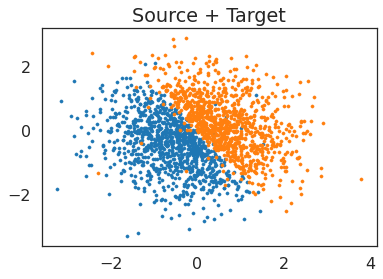

In [14]:
# encode data points
flow_train_x, _ = flow.forward(torch.from_numpy(X).cuda().float())
flow_test_x, _ = flow.forward(torch.from_numpy(Z).cuda().float())

plt.scatter(flow_train_x[:,0].data.cpu().numpy(), flow_train_x[:,1].data.cpu().numpy(), s=10)
plt.scatter(flow_test_x[:,0].data.cpu().numpy(), flow_test_x[:,1].data.cpu().numpy(), s=10)

plt.title('Source + Target')

### train KLIEP on z

In [15]:
flow_x = flow_train_x.data.cpu().numpy()
flow_z = flow_test_x.data.cpu().numpy()

In [16]:
kliep = DensityRatioEstimator()
kliep.fit(flow_x, flow_z) # keyword arguments are X_train and X_test
z_weights = kliep.predict(flow_x)

/atlas/u/kechoi/pykliep/pykliep.py:168: RuntimeWarning: divide by zero encountered in true_divide
  out += epsilon*np.dot(np.transpose(A),1./np.dot(A,out))


In [17]:
# Train via KLIEP
clf = LogisticRegression()
# clf.fit(flow_x, y, sample_weight=z_weights)
# pred_adapt = clf.predict(flow_z)
clf.fit(X, y, sample_weight=z_weights)
pred_adapt = clf.predict(Z)

# Compute error rates
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))

Error adapt: 0.223


In [18]:
# target test
flow_test_real, _ = flow(torch.from_numpy(Z_test).float().cuda())
# pred_adapt_test = clf.predict(flow_test_real.data.cpu().numpy())
pred_adapt_test = clf.predict(Z_test)
print('Error adapt in z-space: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error adapt in z-space: 0.201


Target
- Error naive: 0.297
- Error adapt: 0.233
- Error adapt (z-space): 0.223

Target (test)
- Error naive: 0.286
- Error adapt: 0.208
- Error adapt (z-space): 0.201

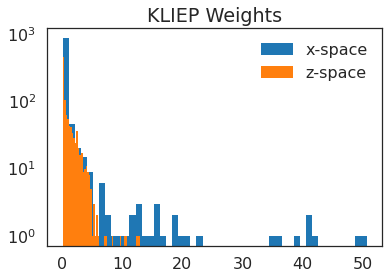

In [17]:
_ = plt.hist(x_weights, bins=50, label='x-space')
_ = plt.hist(z_weights, bins=50, label='z-space')
plt.yscale('log')

plt.title('KLIEP Weights')
plt.legend()

---------

### What if I do the entire thing in z-space?

In [20]:
# Train via KLIEP
clf = LogisticRegression()
clf.fit(flow_x, y, sample_weight=z_weights)
pred_adapt = clf.predict(flow_z)

# Compute error rates
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))

Error adapt: 0.344


In [21]:
# target test
flow_test_real, _ = flow(torch.from_numpy(Z_test).float().cuda())
pred_adapt_test = clf.predict(flow_test_real.data.cpu().numpy())
print('Error adapt in z-space: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error adapt in z-space: 0.336


----

### naive LR in z-space

In [27]:
lr = LogisticRegression()
lr.fit(flow_x, y)
pred_naive = lr.predict(flow_z)

# Compute error rates
print('Error naive in z-space: ' + str(np.mean(pred_naive != u, axis=0)))

Error naive in z-space: 0.635


In [28]:
# target test
flow_test_real, _ = flow(torch.from_numpy(Z_test).float().cuda())
pred_naive_test = lr.predict(flow_test_real.data.cpu().numpy())
print('Error naive (test) in z-space: ' + str(np.mean(pred_naive_test != u_test, axis=0)))

Error naive (test) in z-space: 0.629


---

# Weights

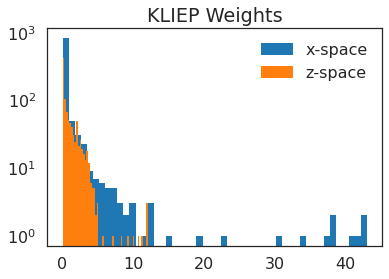

In [36]:
_ = plt.hist(weights, bins=50, label='x-space')
_ = plt.hist(z_weights, bins=50, label='z-space')
plt.yscale('log')

plt.title('KLIEP Weights')
plt.legend()